In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_Cinic10(nn.Module):
    def __init__(self):
        super(CNN_Cinic10, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 2048, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(2048, 512)
        self.z_log_var = nn.Linear(2048, 512)

        self.decoder = nn.Sequential(
            nn.Linear(512, 2048),
            nn.Unflatten(1, (2048, 1, 1)),
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),            
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

    def get_latent(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)

        return lat

In [3]:
mean = [0.47889522, 0.47227842, 0.43047404]
std = [0.24205776, 0.23828046, 0.25874835]

transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

root_dir = '/media/mountHDD2/data/cinic10'

trainset = ImageFolder(root=root_dir + "/train", transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=24)
validset = ImageFolder(root=root_dir + "/valid", transform=transform)
valid_dl = DataLoader(validset, batch_size=128, shuffle=False, num_workers=24)
testset = ImageFolder(root=root_dir + "/test", transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=24)

print(len(trainset), len(validset), len(testset))
print(len(train_dl), len(valid_dl), len(test_dl))

90000 90000 90000
704 704 704


In [4]:
sample, _ = trainset[0]
print(sample.shape)

torch.Size([3, 32, 32])


In [5]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Cinic10().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 200

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [7]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()f

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(valid_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 130.78it/s]


Epoch: 0 - TrainRecLoss: 2310.3771476745605 - ValidRecLoss: 1820.1441914818504
Epoch: 0 - TrainDivLoss: 11168.42457205599 - ValidDivLoss: 181.24068798802116


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 130.46it/s]


Epoch: 1 - TrainRecLoss: 1669.6753748113458 - ValidRecLoss: 1610.310087030584
Epoch: 1 - TrainDivLoss: 166.28234174034813 - ValidDivLoss: 186.84129066900775


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.53it/s]


Epoch: 2 - TrainRecLoss: 1496.5182730934837 - ValidRecLoss: 1573.8471537503328
Epoch: 2 - TrainDivLoss: 149.89594171263954 - ValidDivLoss: 153.2697972492738


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 131.21it/s]


Epoch: 3 - TrainRecLoss: 1384.1764125823975 - ValidRecLoss: 1372.9875780452383
Epoch: 3 - TrainDivLoss: 119.49952799623662 - ValidDivLoss: 116.17787500945005


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 130.27it/s]


Epoch: 4 - TrainRecLoss: 1303.0292240489614 - ValidRecLoss: 1362.3179002241654
Epoch: 4 - TrainDivLoss: 126.4462392763658 - ValidDivLoss: 211.7036373723637


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 129.08it/s]


Epoch: 5 - TrainRecLoss: 1249.545905720104 - ValidRecLoss: 1371.6666193008423
Epoch: 5 - TrainDivLoss: 115.09736040505496 - ValidDivLoss: 160.16372434659436


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 129.22it/s]


Epoch: 6 - TrainRecLoss: 1209.2486678036776 - ValidRecLoss: 1261.9613552960482
Epoch: 6 - TrainDivLoss: 96.39203795519742 - ValidDivLoss: 105.75644637237896


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 129.11it/s]


Epoch: 7 - TrainRecLoss: 1176.798751224171 - ValidRecLoss: 1161.610992865129
Epoch: 7 - TrainDivLoss: 89.86508303338832 - ValidDivLoss: 94.12877733599056


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.51it/s]


Epoch: 8 - TrainRecLoss: 1136.358715317466 - ValidRecLoss: 1169.679540200667
Epoch: 8 - TrainDivLoss: 84.92726936665449 - ValidDivLoss: 101.70427895676006


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.78it/s]


Epoch: 9 - TrainRecLoss: 1103.8377454931085 - ValidRecLoss: 1132.175611409274
Epoch: 9 - TrainDivLoss: 73.606342559511 - ValidDivLoss: 75.41125228188254


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 129.03it/s]


Epoch: 10 - TrainRecLoss: 1085.0500970320268 - ValidRecLoss: 1206.776927947998
Epoch: 10 - TrainDivLoss: 70.20880433646116 - ValidDivLoss: 88.47549433599819


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 129.42it/s]


Epoch: 11 - TrainRecLoss: 1062.2246526371348 - ValidRecLoss: 1300.2234215302901
Epoch: 11 - TrainDivLoss: 69.50142260031267 - ValidDivLoss: 191.92981132594022


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.14it/s]


Epoch: 12 - TrainRecLoss: 1038.954525340687 - ValidRecLoss: 1035.084802974354
Epoch: 12 - TrainDivLoss: 71.18653708154505 - ValidDivLoss: 71.03486941619353


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.40it/s]


Epoch: 13 - TrainRecLoss: 1009.3647814663974 - ValidRecLoss: 1045.373741756786
Epoch: 13 - TrainDivLoss: 67.05337218262933 - ValidDivLoss: 91.4433158419349


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.26it/s]


Epoch: 14 - TrainRecLoss: 990.9598204005848 - ValidRecLoss: 1111.5722701332786
Epoch: 14 - TrainDivLoss: 67.87555632807992 - ValidDivLoss: 272.1788654760881


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 129.70it/s]


Epoch: 15 - TrainRecLoss: 987.4963463002986 - ValidRecLoss: 992.6079354286194
Epoch: 15 - TrainDivLoss: 68.96626180410385 - ValidDivLoss: 63.50532349673185


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 129.14it/s]


Epoch: 16 - TrainRecLoss: 967.7297708337957 - ValidRecLoss: 963.5230097770691
Epoch: 16 - TrainDivLoss: 61.39410346204584 - ValidDivLoss: 60.24624145030975


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.95it/s]


Epoch: 17 - TrainRecLoss: 954.7793784575028 - ValidRecLoss: 959.8038967305964
Epoch: 17 - TrainDivLoss: 60.554911494255066 - ValidDivLoss: 61.39626436341893


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 129.49it/s]


Epoch: 18 - TrainRecLoss: 945.2195465781472 - ValidRecLoss: 940.2857151898471
Epoch: 18 - TrainDivLoss: 60.766457655213095 - ValidDivLoss: 60.39941863038323


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.67it/s]


Epoch: 19 - TrainRecLoss: 931.766187581149 - ValidRecLoss: 922.9311291087757
Epoch: 19 - TrainDivLoss: 61.57974632761695 - ValidDivLoss: 61.542806094343014


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.45it/s]


Epoch: 20 - TrainRecLoss: 923.4565779946067 - ValidRecLoss: 910.7154458652843
Epoch: 20 - TrainDivLoss: 62.342245464975186 - ValidDivLoss: 63.771276306022294


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.99it/s]


Epoch: 21 - TrainRecLoss: 915.4763966473666 - ValidRecLoss: 909.4279752644626
Epoch: 21 - TrainDivLoss: 63.25325278260491 - ValidDivLoss: 63.725957063111395


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.23it/s]


Epoch: 22 - TrainRecLoss: 906.3125198537654 - ValidRecLoss: 954.807240486145
Epoch: 22 - TrainDivLoss: 64.54430869492617 - ValidDivLoss: 65.58941581032492


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 127.32it/s]


Epoch: 23 - TrainRecLoss: 925.9232704856179 - ValidRecLoss: 900.2931028279392
Epoch: 23 - TrainDivLoss: 66.98743251237002 - ValidDivLoss: 65.5135889324275


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 130.21it/s]


Epoch: 24 - TrainRecLoss: 900.0338232733986 - ValidRecLoss: 898.7493030808189
Epoch: 24 - TrainDivLoss: 65.04416686296463 - ValidDivLoss: 65.18177377093922


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.49it/s]


Epoch: 25 - TrainRecLoss: 892.5508320548317 - ValidRecLoss: 917.2749342918396
Epoch: 25 - TrainDivLoss: 65.19939253546976 - ValidDivLoss: 66.61205552924763


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.50it/s]


Epoch: 26 - TrainRecLoss: 890.3876412998546 - ValidRecLoss: 884.9678181301464
Epoch: 26 - TrainDivLoss: 65.63622980768031 - ValidDivLoss: 65.92448429085992


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.81it/s]


Epoch: 27 - TrainRecLoss: 880.5380311445756 - ValidRecLoss: 880.373807777058
Epoch: 27 - TrainDivLoss: 66.3816771182147 - ValidDivLoss: 66.2101240049709


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 129.82it/s]


Epoch: 28 - TrainRecLoss: 876.4893156398426 - ValidRecLoss: 878.79871524464
Epoch: 28 - TrainDivLoss: 67.19731420820409 - ValidDivLoss: 67.18054353107105


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 129.42it/s]


Epoch: 29 - TrainRecLoss: 871.6986869465221 - ValidRecLoss: 875.8908268755132
Epoch: 29 - TrainDivLoss: 67.79020459001714 - ValidDivLoss: 67.9549286311323


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.96it/s]


Epoch: 30 - TrainRecLoss: 867.2627258300781 - ValidRecLoss: 868.7543173269792
Epoch: 30 - TrainDivLoss: 67.94035974415866 - ValidDivLoss: 67.6020035093481


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 129.00it/s]


Epoch: 31 - TrainRecLoss: 863.6206481240013 - ValidRecLoss: 863.7648953524503
Epoch: 31 - TrainDivLoss: 68.01689876209606 - ValidDivLoss: 67.17687217755751


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 129.55it/s]


Epoch: 32 - TrainRecLoss: 861.6703331687233 - ValidRecLoss: 861.4195176904851
Epoch: 32 - TrainDivLoss: 68.1080094792626 - ValidDivLoss: 68.25227691368623


100%|█████████████████████████████████████████████████████████████████| 704/704 [00:05<00:00, 128.23it/s]


Epoch: 33 - TrainRecLoss: 858.2097684686834 - ValidRecLoss: 859.7844057950107
Epoch: 33 - TrainDivLoss: 68.14056160233237 - ValidDivLoss: 67.9120878143744


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.94it/s]


Epoch: 34 - TrainRecLoss: 854.3493178107522 - ValidRecLoss: 855.1124567118558
Epoch: 34 - TrainDivLoss: 68.65446788614446 - ValidDivLoss: 68.54467299309644


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.09it/s]


Epoch: 35 - TrainRecLoss: 851.3142134926536 - ValidRecLoss: 857.362177588723
Epoch: 35 - TrainDivLoss: 69.07642545483328 - ValidDivLoss: 69.62852849743582


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.80it/s]


Epoch: 36 - TrainRecLoss: 847.6113316796043 - ValidRecLoss: 855.8675377152183
Epoch: 36 - TrainDivLoss: 69.12201055613431 - ValidDivLoss: 69.36357227780603


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.70it/s]


Epoch: 37 - TrainRecLoss: 845.3088971051303 - ValidRecLoss: 847.9900300286033
Epoch: 37 - TrainDivLoss: 69.22487235069275 - ValidDivLoss: 69.31328994577581


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.16it/s]


Epoch: 38 - TrainRecLoss: 843.0231278159401 - ValidRecLoss: 846.3579323075035
Epoch: 38 - TrainDivLoss: 69.37784336913715 - ValidDivLoss: 69.58969992941076


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.88it/s]


Epoch: 39 - TrainRecLoss: 840.7938451766968 - ValidRecLoss: 844.1914654211564
Epoch: 39 - TrainDivLoss: 69.39231087944724 - ValidDivLoss: 69.19777040589939


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.68it/s]


Epoch: 40 - TrainRecLoss: 838.4673991636796 - ValidRecLoss: 849.6110100312667
Epoch: 40 - TrainDivLoss: 69.48995023423976 - ValidDivLoss: 69.05723684484309


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 74.73it/s]


Epoch: 41 - TrainRecLoss: 835.7424382296475 - ValidRecLoss: 845.988723971627
Epoch: 41 - TrainDivLoss: 69.56433802301234 - ValidDivLoss: 70.80565577745438


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 75.60it/s]


Epoch: 42 - TrainRecLoss: 833.519210728732 - ValidRecLoss: 845.6908202171326
Epoch: 42 - TrainDivLoss: 69.56754520806399 - ValidDivLoss: 69.31158817356282


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.11it/s]


Epoch: 43 - TrainRecLoss: 831.7832065929066 - ValidRecLoss: 851.7042935111306
Epoch: 43 - TrainDivLoss: 69.70723867416382 - ValidDivLoss: 69.71721674637361


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.70it/s]


Epoch: 44 - TrainRecLoss: 829.9098470861262 - ValidRecLoss: 845.5566802458329
Epoch: 44 - TrainDivLoss: 69.7333153702996 - ValidDivLoss: 70.20626087080349


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.33it/s]


Epoch: 45 - TrainRecLoss: 827.2509878331965 - ValidRecLoss: 844.1767863360318
Epoch: 45 - TrainDivLoss: 70.14974364367399 - ValidDivLoss: 70.59426455606113


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.32it/s]


Epoch: 46 - TrainRecLoss: 824.2195218693126 - ValidRecLoss: 836.2242615439675
Epoch: 46 - TrainDivLoss: 70.55520834706046 - ValidDivLoss: 69.55104625225067


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.92it/s]


Epoch: 47 - TrainRecLoss: 821.2947630448775 - ValidRecLoss: 835.953245639801
Epoch: 47 - TrainDivLoss: 70.72970327464017 - ValidDivLoss: 69.98286765271968


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.99it/s]


Epoch: 48 - TrainRecLoss: 819.5332828868519 - ValidRecLoss: 836.3784580664201
Epoch: 48 - TrainDivLoss: 70.87828212434596 - ValidDivLoss: 69.68943703716451


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.90it/s]


Epoch: 49 - TrainRecLoss: 818.1306006691673 - ValidRecLoss: 840.3330294869163
Epoch: 49 - TrainDivLoss: 70.98268710483204 - ValidDivLoss: 70.93458739194003


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.64it/s]


Epoch: 50 - TrainRecLoss: 816.2492143457586 - ValidRecLoss: 839.2070852192966
Epoch: 50 - TrainDivLoss: 71.06823551654816 - ValidDivLoss: 70.37198662757874


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.14it/s]


Epoch: 51 - TrainRecLoss: 814.8689851760864 - ValidRecLoss: 833.2964274233037
Epoch: 51 - TrainDivLoss: 71.20510944453153 - ValidDivLoss: 70.84614498506893


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.77it/s]


Epoch: 52 - TrainRecLoss: 813.1356547962536 - ValidRecLoss: 836.6521469463001
Epoch: 52 - TrainDivLoss: 71.37556311217222 - ValidDivLoss: 70.31121725385839


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.06it/s]


Epoch: 53 - TrainRecLoss: 811.2185333425349 - ValidRecLoss: 836.8331467021595
Epoch: 53 - TrainDivLoss: 71.80019244280729 - ValidDivLoss: 72.17201565070586


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.88it/s]


Epoch: 54 - TrainRecLoss: 808.6867969686335 - ValidRecLoss: 835.551305770874
Epoch: 54 - TrainDivLoss: 72.04240302606063 - ValidDivLoss: 72.05479445782575


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.83it/s]


Epoch: 55 - TrainRecLoss: 807.0706136876887 - ValidRecLoss: 836.2276345599781
Epoch: 55 - TrainDivLoss: 72.20308030735363 - ValidDivLoss: 72.6448237137361


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.09it/s]


Epoch: 56 - TrainRecLoss: 806.0209408673373 - ValidRecLoss: 829.0435608950528
Epoch: 56 - TrainDivLoss: 72.31075070121072 - ValidDivLoss: 71.93795384602113


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.79it/s]


Epoch: 57 - TrainRecLoss: 804.5018698085438 - ValidRecLoss: 833.9009691585194
Epoch: 57 - TrainDivLoss: 72.42050747437911 - ValidDivLoss: 72.22590655630285


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 77.75it/s]


Epoch: 58 - TrainRecLoss: 802.7299244620583 - ValidRecLoss: 834.5138692422347
Epoch: 58 - TrainDivLoss: 72.43805115873164 - ValidDivLoss: 72.43838759443976


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:08<00:00, 78.44it/s]


Epoch: 59 - TrainRecLoss: 801.6081039255315 - ValidRecLoss: 833.1953984173862
Epoch: 59 - TrainDivLoss: 72.6023718552156 - ValidDivLoss: 71.91748465733095


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.65it/s]


Epoch: 60 - TrainRecLoss: 800.1833691163497 - ValidRecLoss: 833.0988509438255
Epoch: 60 - TrainDivLoss: 72.65697740424763 - ValidDivLoss: 72.4022199457342


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.51it/s]


Epoch: 61 - TrainRecLoss: 799.3652751229026 - ValidRecLoss: 832.6623908823186
Epoch: 61 - TrainDivLoss: 72.72707621617751 - ValidDivLoss: 71.78411782871594


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.62it/s]


Epoch: 62 - TrainRecLoss: 797.8845963911576 - ValidRecLoss: 835.7744761380283
Epoch: 62 - TrainDivLoss: 72.84228574145924 - ValidDivLoss: 71.69251370971853


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.95it/s]


Epoch: 63 - TrainRecLoss: 796.4160327911377 - ValidRecLoss: 835.2637181282043
Epoch: 63 - TrainDivLoss: 72.94124798341231 - ValidDivLoss: 73.12561777505007


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.20it/s]


Epoch: 64 - TrainRecLoss: 795.1229309602218 - ValidRecLoss: 832.4362681995739
Epoch: 64 - TrainDivLoss: 73.10868834365498 - ValidDivLoss: 72.28555994142185


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.66it/s]


Epoch: 65 - TrainRecLoss: 793.7497357455167 - ValidRecLoss: 830.6542391343551
Epoch: 65 - TrainDivLoss: 73.3442313454368 - ValidDivLoss: 74.05967882004651


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.23it/s]


Epoch: 66 - TrainRecLoss: 791.7848700610074 - ValidRecLoss: 834.1656172925776
Epoch: 66 - TrainDivLoss: 73.66028968854384 - ValidDivLoss: 73.84193647991528


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 71.36it/s]


Epoch: 67 - TrainRecLoss: 790.9582210887562 - ValidRecLoss: 830.8346754854375
Epoch: 67 - TrainDivLoss: 73.77289568294178 - ValidDivLoss: 74.25193127176978


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.69it/s]


Epoch: 68 - TrainRecLoss: 789.1068566062233 - ValidRecLoss: 826.8106715895913
Epoch: 68 - TrainDivLoss: 73.79937632517381 - ValidDivLoss: 75.16437391259454


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.64it/s]


Epoch: 69 - TrainRecLoss: 787.7137294249101 - ValidRecLoss: 835.0357203483582
Epoch: 69 - TrainDivLoss: 73.98228179324757 - ValidDivLoss: 74.37170852856202


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.84it/s]


Epoch: 70 - TrainRecLoss: 787.289835062894 - ValidRecLoss: 833.393644506281
Epoch: 70 - TrainDivLoss: 74.10561095584522 - ValidDivLoss: 73.46894447911869


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.37it/s]


Epoch: 71 - TrainRecLoss: 785.2918586730957 - ValidRecLoss: 827.3320813179016
Epoch: 71 - TrainDivLoss: 74.1293302340941 - ValidDivLoss: 74.53722243959254


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.29it/s]


Epoch: 72 - TrainRecLoss: 784.3528944362293 - ValidRecLoss: 830.2838941487399
Epoch: 72 - TrainDivLoss: 74.23084859414534 - ValidDivLoss: 73.83242064714432


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.52it/s]


Epoch: 73 - TrainRecLoss: 783.4903003519231 - ValidRecLoss: 830.9638327685269
Epoch: 73 - TrainDivLoss: 74.30226334658536 - ValidDivLoss: 76.216536229307


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.61it/s]


Epoch: 74 - TrainRecLoss: 782.2248525619507 - ValidRecLoss: 831.3263993263245
Epoch: 74 - TrainDivLoss: 74.40455778078599 - ValidDivLoss: 73.71711127324538


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 74.74it/s]


Epoch: 75 - TrainRecLoss: 780.7886024821888 - ValidRecLoss: 829.0029158592224
Epoch: 75 - TrainDivLoss: 74.50204922936179 - ValidDivLoss: 74.99411047046834


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 75.02it/s]


Epoch: 76 - TrainRecLoss: 779.5637267719616 - ValidRecLoss: 828.0409167029641
Epoch: 76 - TrainDivLoss: 74.64136625419964 - ValidDivLoss: 74.13457740978761


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.43it/s]


Epoch: 77 - TrainRecLoss: 778.4349263798107 - ValidRecLoss: 825.8424576846036
Epoch: 77 - TrainDivLoss: 74.74423597075723 - ValidDivLoss: 74.72849581458352


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.86it/s]


Epoch: 78 - TrainRecLoss: 775.7288721257991 - ValidRecLoss: 826.7504982948303
Epoch: 78 - TrainDivLoss: 74.9180339683186 - ValidDivLoss: 73.98508821834217


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.33it/s]


Epoch: 79 - TrainRecLoss: 774.4513063430786 - ValidRecLoss: 830.90424043482
Epoch: 79 - TrainDivLoss: 75.06447553634644 - ValidDivLoss: 75.1401558843526


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.52it/s]


Epoch: 80 - TrainRecLoss: 773.7164902253585 - ValidRecLoss: 826.0447252013466
Epoch: 80 - TrainDivLoss: 75.25474354353818 - ValidDivLoss: 75.13739008795132


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.78it/s]


Epoch: 81 - TrainRecLoss: 772.3406489979137 - ValidRecLoss: 826.7073739225215
Epoch: 81 - TrainDivLoss: 75.31227380579168 - ValidDivLoss: 74.20434973456643


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.46it/s]


Epoch: 82 - TrainRecLoss: 771.2073189128529 - ValidRecLoss: 826.3921863382512
Epoch: 82 - TrainDivLoss: 75.34092356941916 - ValidDivLoss: 74.28977809169076


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.66it/s]


Epoch: 83 - TrainRecLoss: 770.3265823017467 - ValidRecLoss: 828.4367541833358
Epoch: 83 - TrainDivLoss: 75.48439170013775 - ValidDivLoss: 75.21734357422048


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.29it/s]


Epoch: 84 - TrainRecLoss: 769.1348634199662 - ValidRecLoss: 825.08777774464
Epoch: 84 - TrainDivLoss: 75.54864050041546 - ValidDivLoss: 75.61270908334039


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.83it/s]


Epoch: 85 - TrainRecLoss: 768.6104679974643 - ValidRecLoss: 827.8726713874123
Epoch: 85 - TrainDivLoss: 75.62488255717538 - ValidDivLoss: 74.74241031299938


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.78it/s]


Epoch: 86 - TrainRecLoss: 767.8868407336148 - ValidRecLoss: 825.0557505867698
Epoch: 86 - TrainDivLoss: 75.74131721800023 - ValidDivLoss: 75.45143394578587


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.74it/s]


Epoch: 87 - TrainRecLoss: 766.1624269485474 - ValidRecLoss: 827.1733381531456
Epoch: 87 - TrainDivLoss: 75.80645720525222 - ValidDivLoss: 76.43918981335379


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.31it/s]


Epoch: 88 - TrainRecLoss: 765.91639102589 - ValidRecLoss: 825.7980706041509
Epoch: 88 - TrainDivLoss: 75.83783227747136 - ValidDivLoss: 74.83363291350278


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.51it/s]


Epoch: 89 - TrainRecLoss: 764.9674626263705 - ValidRecLoss: 823.0996554548091
Epoch: 89 - TrainDivLoss: 75.94068139249629 - ValidDivLoss: 75.02379116686907


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.53it/s]


Epoch: 90 - TrainRecLoss: 764.143127528104 - ValidRecLoss: 824.1182144771923
Epoch: 90 - TrainDivLoss: 75.95735104517503 - ValidDivLoss: 75.08185579560019


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.25it/s]


Epoch: 91 - TrainRecLoss: 763.0313711166382 - ValidRecLoss: 828.6765108975497
Epoch: 91 - TrainDivLoss: 76.1085737510161 - ValidDivLoss: 74.84845223210074


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 76.11it/s]


Epoch: 92 - TrainRecLoss: 762.2748609889637 - ValidRecLoss: 826.1280299966985
Epoch: 92 - TrainDivLoss: 76.11737575314261 - ValidDivLoss: 77.0565755204721


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 75.90it/s]


Epoch: 93 - TrainRecLoss: 760.7829210107976 - ValidRecLoss: 824.1925683888522
Epoch: 93 - TrainDivLoss: 76.14491483298215 - ValidDivLoss: 75.9391409646381


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.25it/s]


Epoch: 94 - TrainRecLoss: 760.0826633626765 - ValidRecLoss: 824.2520909309387
Epoch: 94 - TrainDivLoss: 76.22678128155795 - ValidDivLoss: 76.69488392092966


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.71it/s]


Epoch: 95 - TrainRecLoss: 759.2410148273815 - ValidRecLoss: 825.1320009665055
Epoch: 95 - TrainDivLoss: 76.29787920821796 - ValidDivLoss: 76.322174039754


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.62it/s]


Epoch: 96 - TrainRecLoss: 758.661846334284 - ValidRecLoss: 831.1488902352073
Epoch: 96 - TrainDivLoss: 76.40727422454141 - ValidDivLoss: 75.53332917256789


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.21it/s]


Epoch: 97 - TrainRecLoss: 757.967168114402 - ValidRecLoss: 827.5854328328913
Epoch: 97 - TrainDivLoss: 76.40725567124106 - ValidDivLoss: 75.88861738551746


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.90it/s]


Epoch: 98 - TrainRecLoss: 756.8813433213668 - ValidRecLoss: 827.8636243126609
Epoch: 98 - TrainDivLoss: 76.52643891898069 - ValidDivLoss: 76.2480477961627


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.71it/s]


Epoch: 99 - TrainRecLoss: 755.782078742981 - ValidRecLoss: 824.8610778721896
Epoch: 99 - TrainDivLoss: 76.55080370469527 - ValidDivLoss: 75.80703199993481


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.09it/s]


Epoch: 100 - TrainRecLoss: 754.9458296515725 - ValidRecLoss: 825.772664937106
Epoch: 100 - TrainDivLoss: 76.61826559630308 - ValidDivLoss: 76.12932077863


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.99it/s]


Epoch: 101 - TrainRecLoss: 753.7945996197788 - ValidRecLoss: 824.8573487888683
Epoch: 101 - TrainDivLoss: 76.64889280362563 - ValidDivLoss: 75.80532630465247


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.31it/s]


Epoch: 102 - TrainRecLoss: 753.192423213612 - ValidRecLoss: 828.7042890895497
Epoch: 102 - TrainDivLoss: 76.6848477450284 - ValidDivLoss: 76.40502552552657


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.89it/s]


Epoch: 103 - TrainRecLoss: 752.8675296089866 - ValidRecLoss: 825.9889926476912
Epoch: 103 - TrainDivLoss: 76.7613158117641 - ValidDivLoss: 76.7368128191341


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.52it/s]


Epoch: 104 - TrainRecLoss: 751.6917098652233 - ValidRecLoss: 824.6624073548751
Epoch: 104 - TrainDivLoss: 76.8084128553217 - ValidDivLoss: 76.55695013566451


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.95it/s]


Epoch: 105 - TrainRecLoss: 751.05168169195 - ValidRecLoss: 825.5227544090965
Epoch: 105 - TrainDivLoss: 76.91025296124545 - ValidDivLoss: 76.9694689837369


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.51it/s]


Epoch: 106 - TrainRecLoss: 749.6349583539096 - ValidRecLoss: 824.8554699204185
Epoch: 106 - TrainDivLoss: 76.94448879632083 - ValidDivLoss: 77.67065615003759


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.31it/s]


Epoch: 107 - TrainRecLoss: 749.0226809761741 - ValidRecLoss: 827.4174724925648
Epoch: 107 - TrainDivLoss: 76.99069704792716 - ValidDivLoss: 76.13055834986947


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.79it/s]


Epoch: 108 - TrainRecLoss: 748.2752465334805 - ValidRecLoss: 824.0344479300759
Epoch: 108 - TrainDivLoss: 77.02454418485814 - ValidDivLoss: 75.83341319994493


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.21it/s]


Epoch: 109 - TrainRecLoss: 747.7869306911122 - ValidRecLoss: 823.910367792303
Epoch: 109 - TrainDivLoss: 77.06085590882735 - ValidDivLoss: 77.14236146753484


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.55it/s]


Epoch: 110 - TrainRecLoss: 747.1671640222722 - ValidRecLoss: 825.7957064455205
Epoch: 110 - TrainDivLoss: 77.14112029292367 - ValidDivLoss: 76.80257823792371


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.23it/s]


Epoch: 111 - TrainRecLoss: 746.3932167400013 - ValidRecLoss: 827.2371291247281
Epoch: 111 - TrainDivLoss: 77.21922086585651 - ValidDivLoss: 76.93989213488318


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.68it/s]


Epoch: 112 - TrainRecLoss: 745.5617182471535 - ValidRecLoss: 825.0812825289639
Epoch: 112 - TrainDivLoss: 77.23781150037593 - ValidDivLoss: 76.59708974036303


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.63it/s]


Epoch: 113 - TrainRecLoss: 744.8725075288253 - ValidRecLoss: 829.7970201752403
Epoch: 113 - TrainDivLoss: 77.32579640908675 - ValidDivLoss: 76.74744407155298


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.97it/s]


Epoch: 114 - TrainRecLoss: 744.4362354278564 - ValidRecLoss: 826.594083959406
Epoch: 114 - TrainDivLoss: 77.34923827648163 - ValidDivLoss: 77.40249089761214


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.46it/s]


Epoch: 115 - TrainRecLoss: 743.3774029991844 - ValidRecLoss: 825.3338019631126
Epoch: 115 - TrainDivLoss: 77.35460456934842 - ValidDivLoss: 77.47875978729941


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.92it/s]


Epoch: 116 - TrainRecLoss: 743.3897916620427 - ValidRecLoss: 825.5490664568814
Epoch: 116 - TrainDivLoss: 77.43197133324362 - ValidDivLoss: 75.96466211297296


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.63it/s]


Epoch: 117 - TrainRecLoss: 742.5103998184204 - ValidRecLoss: 828.5629774006931
Epoch: 117 - TrainDivLoss: 77.47999621521343 - ValidDivLoss: 78.13360339945012


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.40it/s]


Epoch: 118 - TrainRecLoss: 741.7205706509677 - ValidRecLoss: 827.438609383323
Epoch: 118 - TrainDivLoss: 77.52465230768377 - ValidDivLoss: 76.28300508585843


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.31it/s]


Epoch: 119 - TrainRecLoss: 741.3107890215787 - ValidRecLoss: 825.4495772014965
Epoch: 119 - TrainDivLoss: 77.5605577772314 - ValidDivLoss: 77.47805055704984


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.13it/s]


Epoch: 120 - TrainRecLoss: 740.5286892110652 - ValidRecLoss: 828.2920519221913
Epoch: 120 - TrainDivLoss: 77.62117703394456 - ValidDivLoss: 77.51025076345964


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.80it/s]


Epoch: 121 - TrainRecLoss: 740.1101546721025 - ValidRecLoss: 829.2642143856395
Epoch: 121 - TrainDivLoss: 77.7026738470251 - ValidDivLoss: 76.36711443554272


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.10it/s]


Epoch: 122 - TrainRecLoss: 739.6227054595947 - ValidRecLoss: 829.0044093998996
Epoch: 122 - TrainDivLoss: 77.7570691542192 - ValidDivLoss: 76.16944239898162


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.61it/s]


Epoch: 123 - TrainRecLoss: 738.8650425130671 - ValidRecLoss: 826.3039175813848
Epoch: 123 - TrainDivLoss: 77.78368962894787 - ValidDivLoss: 77.26496195251292


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.72it/s]


Epoch: 124 - TrainRecLoss: 737.7105412916703 - ValidRecLoss: 828.3160230029713
Epoch: 124 - TrainDivLoss: 77.85058491880244 - ValidDivLoss: 77.93441291830756


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.58it/s]


Epoch: 125 - TrainRecLoss: 737.1140064759688 - ValidRecLoss: 825.4837056940252
Epoch: 125 - TrainDivLoss: 77.91474721648477 - ValidDivLoss: 77.46451213143088


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 75.92it/s]


Epoch: 126 - TrainRecLoss: 736.4930655739524 - ValidRecLoss: 828.2184048565952
Epoch: 126 - TrainDivLoss: 77.89941968701102 - ValidDivLoss: 77.46819738366388


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 75.20it/s]


Epoch: 127 - TrainRecLoss: 736.2298936843872 - ValidRecLoss: 827.4595112800598
Epoch: 127 - TrainDivLoss: 77.9170492887497 - ValidDivLoss: 77.42198053273287


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.11it/s]


Epoch: 128 - TrainRecLoss: 735.8874949541959 - ValidRecLoss: 827.4882847612554
Epoch: 128 - TrainDivLoss: 78.05600988864899 - ValidDivLoss: 77.198653540828


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.44it/s]


Epoch: 129 - TrainRecLoss: 735.2174025448886 - ValidRecLoss: 825.9867074706337
Epoch: 129 - TrainDivLoss: 78.05702441388911 - ValidDivLoss: 77.32069596377286


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.48it/s]


Epoch: 130 - TrainRecLoss: 734.7678909301758 - ValidRecLoss: 827.3883136402477
Epoch: 130 - TrainDivLoss: 78.09880577434193 - ValidDivLoss: 77.52094789526679


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.31it/s]


Epoch: 131 - TrainRecLoss: 734.3179925571789 - ValidRecLoss: 826.5003570643338
Epoch: 131 - TrainDivLoss: 78.17054886167699 - ValidDivLoss: 76.9540726759217


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.86it/s]


Epoch: 132 - TrainRecLoss: 733.6447101072831 - ValidRecLoss: 827.1913792436773
Epoch: 132 - TrainDivLoss: 78.26909961483695 - ValidDivLoss: 77.68817801909013


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.82it/s]


Epoch: 133 - TrainRecLoss: 733.0357795195146 - ValidRecLoss: 827.1563798731023
Epoch: 133 - TrainDivLoss: 78.29806605252352 - ValidDivLoss: 77.800285523588


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.56it/s]


Epoch: 134 - TrainRecLoss: 732.1775443337181 - ValidRecLoss: 828.1465269869024
Epoch: 134 - TrainDivLoss: 78.31299550966783 - ValidDivLoss: 78.44399998404764


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.30it/s]


Epoch: 135 - TrainRecLoss: 732.2846458608454 - ValidRecLoss: 827.183073087172
Epoch: 135 - TrainDivLoss: 78.39949586174704 - ValidDivLoss: 77.5968723188747


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.18it/s]


Epoch: 136 - TrainRecLoss: 731.2906858270818 - ValidRecLoss: 828.5782332420349
Epoch: 136 - TrainDivLoss: 78.41267958554354 - ValidDivLoss: 77.60927762768485


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.51it/s]


Epoch: 137 - TrainRecLoss: 730.9559942592274 - ValidRecLoss: 827.7077515342019
Epoch: 137 - TrainDivLoss: 78.49098487333818 - ValidDivLoss: 77.9366030367938


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.52it/s]


Epoch: 138 - TrainRecLoss: 730.0959285389293 - ValidRecLoss: 828.6299508701671
Epoch: 138 - TrainDivLoss: 78.48237849365582 - ValidDivLoss: 78.96690202301198


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.22it/s]


Epoch: 139 - TrainRecLoss: 729.5437697497281 - ValidRecLoss: 827.5366697744889
Epoch: 139 - TrainDivLoss: 78.50590976801786 - ValidDivLoss: 79.05021784522317


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.85it/s]


Epoch: 140 - TrainRecLoss: 729.4707468206233 - ValidRecLoss: 826.2202672958374
Epoch: 140 - TrainDivLoss: 78.5845734314485 - ValidDivLoss: 77.6111481514844


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.88it/s]


Epoch: 141 - TrainRecLoss: 729.080118266019 - ValidRecLoss: 827.208581274206
Epoch: 141 - TrainDivLoss: 78.57991031083193 - ValidDivLoss: 78.6591217842969


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.95it/s]


Epoch: 142 - TrainRecLoss: 728.3209751302546 - ValidRecLoss: 828.3498754501343
Epoch: 142 - TrainDivLoss: 78.66657413135876 - ValidDivLoss: 78.39963668042964


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 75.43it/s]


Epoch: 143 - TrainRecLoss: 727.8556752638383 - ValidRecLoss: 828.3620724244552
Epoch: 143 - TrainDivLoss: 78.69265467470342 - ValidDivLoss: 78.60628828677264


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 76.28it/s]


Epoch: 144 - TrainRecLoss: 727.9039075157859 - ValidRecLoss: 826.8036716201088
Epoch: 144 - TrainDivLoss: 78.71684331243688 - ValidDivLoss: 77.40708647532897


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.75it/s]


Epoch: 145 - TrainRecLoss: 727.0970778031783 - ValidRecLoss: 827.2603194496849
Epoch: 145 - TrainDivLoss: 78.70119852369481 - ValidDivLoss: 78.34557765722275


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.02it/s]


Epoch: 146 - TrainRecLoss: 726.9735506231135 - ValidRecLoss: 828.8275619853626
Epoch: 146 - TrainDivLoss: 78.81124346906489 - ValidDivLoss: 79.00480191815983


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.98it/s]


Epoch: 147 - TrainRecLoss: 726.2201173955744 - ValidRecLoss: 828.8606262207031
Epoch: 147 - TrainDivLoss: 78.84723539785905 - ValidDivLoss: 79.1246460405263


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.98it/s]


Epoch: 148 - TrainRecLoss: 725.8257611014626 - ValidRecLoss: 827.4797365015203
Epoch: 148 - TrainDivLoss: 78.8449672243812 - ValidDivLoss: 78.23457120223479


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.58it/s]


Epoch: 149 - TrainRecLoss: 725.4258218245072 - ValidRecLoss: 828.8748355345292
Epoch: 149 - TrainDivLoss: 78.925133748488 - ValidDivLoss: 78.65794759446925


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.75it/s]


Epoch: 150 - TrainRecLoss: 724.9861316680908 - ValidRecLoss: 828.7056567452171
Epoch: 150 - TrainDivLoss: 78.91165807030417 - ValidDivLoss: 79.21692020242864


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.79it/s]


Epoch: 151 - TrainRecLoss: 724.577448758212 - ValidRecLoss: 828.4148416519165
Epoch: 151 - TrainDivLoss: 78.9005567594008 - ValidDivLoss: 78.91200042854656


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.81it/s]


Epoch: 152 - TrainRecLoss: 724.3062571612271 - ValidRecLoss: 826.7077544385737
Epoch: 152 - TrainDivLoss: 78.95984845811671 - ValidDivLoss: 78.54014683311635


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.74it/s]


Epoch: 153 - TrainRecLoss: 723.9093174500899 - ValidRecLoss: 828.9168797406284
Epoch: 153 - TrainDivLoss: 79.05485971407457 - ValidDivLoss: 78.76652482422915


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.23it/s]


Epoch: 154 - TrainRecLoss: 723.6563118154353 - ValidRecLoss: 827.7600383325057
Epoch: 154 - TrainDivLoss: 79.04453206062317 - ValidDivLoss: 78.91927215727893


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.16it/s]


Epoch: 155 - TrainRecLoss: 723.1198395815762 - ValidRecLoss: 830.0369430888783
Epoch: 155 - TrainDivLoss: 79.03032877228476 - ValidDivLoss: 78.57787784663114


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.93it/s]


Epoch: 156 - TrainRecLoss: 723.4835457368331 - ValidRecLoss: 827.9305765845559
Epoch: 156 - TrainDivLoss: 79.08521190556613 - ValidDivLoss: 78.90117937868291


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.92it/s]


Epoch: 157 - TrainRecLoss: 722.8558040965687 - ValidRecLoss: 828.309329813177
Epoch: 157 - TrainDivLoss: 79.12165121598677 - ValidDivLoss: 78.9309292273088


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.26it/s]


Epoch: 158 - TrainRecLoss: 722.7496185302734 - ValidRecLoss: 826.7096335237676
Epoch: 158 - TrainDivLoss: 79.13839579712261 - ValidDivLoss: 78.35635595430027


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.22it/s]


Epoch: 159 - TrainRecLoss: 722.4235519929366 - ValidRecLoss: 828.2928478067571
Epoch: 159 - TrainDivLoss: 79.15678200938486 - ValidDivLoss: 79.278781701218


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:08<00:00, 79.73it/s]


Epoch: 160 - TrainRecLoss: 721.8249196139249 - ValidRecLoss: 828.6908596212214
Epoch: 160 - TrainDivLoss: 79.19029542532834 - ValidDivLoss: 78.84222486886111


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:08<00:00, 80.27it/s]


Epoch: 161 - TrainRecLoss: 721.8411925922741 - ValidRecLoss: 829.50600901517
Epoch: 161 - TrainDivLoss: 79.21721209179272 - ValidDivLoss: 79.10027437318455


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.59it/s]


Epoch: 162 - TrainRecLoss: 721.0742657401345 - ValidRecLoss: 828.7290301322937
Epoch: 162 - TrainDivLoss: 79.21305963126096 - ValidDivLoss: 79.5018743330782


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.80it/s]


Epoch: 163 - TrainRecLoss: 721.0159341638738 - ValidRecLoss: 828.0072588487105
Epoch: 163 - TrainDivLoss: 79.22761585495688 - ValidDivLoss: 78.8631859475916


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.49it/s]


Epoch: 164 - TrainRecLoss: 720.72233728929 - ValidRecLoss: 826.9996428489685
Epoch: 164 - TrainDivLoss: 79.25704177943143 - ValidDivLoss: 78.52239069613543


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.95it/s]


Epoch: 165 - TrainRecLoss: 720.552429372614 - ValidRecLoss: 828.0576034459201
Epoch: 165 - TrainDivLoss: 79.32698534835468 - ValidDivLoss: 78.6051561778242


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.65it/s]


Epoch: 166 - TrainRecLoss: 720.2921155582775 - ValidRecLoss: 828.6041271903298
Epoch: 166 - TrainDivLoss: 79.29301178455353 - ValidDivLoss: 79.02471836046739


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.96it/s]


Epoch: 167 - TrainRecLoss: 720.1673561442982 - ValidRecLoss: 829.2864290150729
Epoch: 167 - TrainDivLoss: 79.28863912278956 - ValidDivLoss: 78.4176346171986


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.68it/s]


Epoch: 168 - TrainRecLoss: 719.9040731083263 - ValidRecLoss: 829.1983861056241
Epoch: 168 - TrainDivLoss: 79.33398643406954 - ValidDivLoss: 78.95374551144513


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.40it/s]


Epoch: 169 - TrainRecLoss: 719.9443127892234 - ValidRecLoss: 830.7674309557134
Epoch: 169 - TrainDivLoss: 79.38187518986788 - ValidDivLoss: 79.24765076420523


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.74it/s]


Epoch: 170 - TrainRecLoss: 719.5801452289928 - ValidRecLoss: 827.7736574519764
Epoch: 170 - TrainDivLoss: 79.39922906051983 - ValidDivLoss: 78.6322270415046


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.50it/s]


Epoch: 171 - TrainRecLoss: 718.9369209462947 - ValidRecLoss: 828.5685467286544
Epoch: 171 - TrainDivLoss: 79.4071077000011 - ValidDivLoss: 79.57246253707193


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.91it/s]


Epoch: 172 - TrainRecLoss: 719.1909021030773 - ValidRecLoss: 830.1065917882053
Epoch: 172 - TrainDivLoss: 79.4121044549075 - ValidDivLoss: 79.5619508840821


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.50it/s]


Epoch: 173 - TrainRecLoss: 718.9890388141979 - ValidRecLoss: 828.5842436443676
Epoch: 173 - TrainDivLoss: 79.43497441031717 - ValidDivLoss: 78.79838009855963


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.37it/s]


Epoch: 174 - TrainRecLoss: 718.8448333740234 - ValidRecLoss: 828.9017880613154
Epoch: 174 - TrainDivLoss: 79.43256676197052 - ValidDivLoss: 78.63416091962294


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 71.04it/s]


Epoch: 175 - TrainRecLoss: 718.0602527965199 - ValidRecLoss: 829.6378612084823
Epoch: 175 - TrainDivLoss: 79.41954544457522 - ValidDivLoss: 79.09815081141211


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.31it/s]


Epoch: 176 - TrainRecLoss: 718.3846008994362 - ValidRecLoss: 829.8774461312728
Epoch: 176 - TrainDivLoss: 79.38728205724196 - ValidDivLoss: 79.4435764822093


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 77.26it/s]


Epoch: 177 - TrainRecLoss: 718.3713821064342 - ValidRecLoss: 828.3900721289895
Epoch: 177 - TrainDivLoss: 79.48664457147771 - ValidDivLoss: 78.97617623480883


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 76.61it/s]


Epoch: 178 - TrainRecLoss: 718.038815498352 - ValidRecLoss: 828.5995209433815
Epoch: 178 - TrainDivLoss: 79.43184771321036 - ValidDivLoss: 79.06514542211185


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.04it/s]


Epoch: 179 - TrainRecLoss: 717.6751369996505 - ValidRecLoss: 829.1413217024369
Epoch: 179 - TrainDivLoss: 79.4429309909994 - ValidDivLoss: 79.24644297361374


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.77it/s]


Epoch: 180 - TrainRecLoss: 717.91130213304 - ValidRecLoss: 830.2657696550542
Epoch: 180 - TrainDivLoss: 79.52210957353765 - ValidDivLoss: 79.23211510614915


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.36it/s]


Epoch: 181 - TrainRecLoss: 717.7614133141258 - ValidRecLoss: 828.4808335737748
Epoch: 181 - TrainDivLoss: 79.49300168861042 - ValidDivLoss: 78.76102535291152


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.24it/s]


Epoch: 182 - TrainRecLoss: 717.6531745737249 - ValidRecLoss: 830.9674945744601
Epoch: 182 - TrainDivLoss: 79.48147195035762 - ValidDivLoss: 79.23009939085354


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.59it/s]


Epoch: 183 - TrainRecLoss: 717.5799858786843 - ValidRecLoss: 829.723818692294
Epoch: 183 - TrainDivLoss: 79.47784027186307 - ValidDivLoss: 78.66055727005005


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.60it/s]


Epoch: 184 - TrainRecLoss: 717.3999933762984 - ValidRecLoss: 828.8535681637851
Epoch: 184 - TrainDivLoss: 79.49678962880915 - ValidDivLoss: 79.40976656025106


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.48it/s]


Epoch: 185 - TrainRecLoss: 717.2660368139094 - ValidRecLoss: 830.0445536266674
Epoch: 185 - TrainDivLoss: 79.52448977123608 - ValidDivLoss: 79.84651134230874


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.40it/s]


Epoch: 186 - TrainRecLoss: 717.2071261839433 - ValidRecLoss: 830.2622591798955
Epoch: 186 - TrainDivLoss: 79.48720745606856 - ValidDivLoss: 79.4490357095545


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.51it/s]


Epoch: 187 - TrainRecLoss: 717.5549820119685 - ValidRecLoss: 829.4509458975358
Epoch: 187 - TrainDivLoss: 79.51634060252796 - ValidDivLoss: 78.73878464915536


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.29it/s]


Epoch: 188 - TrainRecLoss: 717.0356502532959 - ValidRecLoss: 828.9489569230514
Epoch: 188 - TrainDivLoss: 79.59487168355422 - ValidDivLoss: 79.4458791938695


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.59it/s]


Epoch: 189 - TrainRecLoss: 717.1243964108554 - ValidRecLoss: 830.6009938066655
Epoch: 189 - TrainDivLoss: 79.47572881525213 - ValidDivLoss: 79.41584188287908


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.25it/s]


Epoch: 190 - TrainRecLoss: 717.2316368276423 - ValidRecLoss: 829.6589642438022
Epoch: 190 - TrainDivLoss: 79.51506143266505 - ValidDivLoss: 79.28879090330817


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.55it/s]


Epoch: 191 - TrainRecLoss: 716.9247683611783 - ValidRecLoss: 831.7704515457153
Epoch: 191 - TrainDivLoss: 79.52871938185258 - ValidDivLoss: 79.61172805049203


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.05it/s]


Epoch: 192 - TrainRecLoss: 717.2810543233699 - ValidRecLoss: 828.1317040270025
Epoch: 192 - TrainDivLoss: 79.52912429246035 - ValidDivLoss: 78.70592338930477


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.32it/s]


Epoch: 193 - TrainRecLoss: 716.8954792022705 - ValidRecLoss: 828.7103061242537
Epoch: 193 - TrainDivLoss: 79.53539877588099 - ValidDivLoss: 79.11580361019482


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.96it/s]


Epoch: 194 - TrainRecLoss: 716.8983108347112 - ValidRecLoss: 830.3891613266685
Epoch: 194 - TrainDivLoss: 79.57847345959057 - ValidDivLoss: 79.3607071367177


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.42it/s]


Epoch: 195 - TrainRecLoss: 716.5077127976851 - ValidRecLoss: 830.0319558056918
Epoch: 195 - TrainDivLoss: 79.5493124073202 - ValidDivLoss: 79.22808075493032


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.85it/s]


Epoch: 196 - TrainRecLoss: 717.042085907676 - ValidRecLoss: 828.7277929566123
Epoch: 196 - TrainDivLoss: 79.5375658382069 - ValidDivLoss: 78.97088143500415


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.93it/s]


Epoch: 197 - TrainRecLoss: 716.745478369973 - ValidRecLoss: 829.2310783646324
Epoch: 197 - TrainDivLoss: 79.53009883923964 - ValidDivLoss: 78.86214686523785


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.45it/s]


Epoch: 198 - TrainRecLoss: 716.9547380967574 - ValidRecLoss: 829.748398737474
Epoch: 198 - TrainDivLoss: 79.54278352043845 - ValidDivLoss: 79.42122801325537


100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 73.11it/s]

Epoch: 199 - TrainRecLoss: 716.9586224122481 - ValidRecLoss: 828.1311733505943
Epoch: 199 - TrainDivLoss: 79.53483022343029 - ValidDivLoss: 78.75076898661527


In [8]:
model.eval()
with torch.no_grad():
    va_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for valid_img, _ in tqdm(test_dl):
        valid_img = valid_img.to(device)

        gen_img, valid_mu, valid_lv = model(valid_img)
        valid_rec_loss = loss_fn(gen_img, valid_img)
        valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
        valid_loss = valid_rec_loss + valid_kl_loss

        va_total_loss["rec_loss"] += valid_rec_loss.item()
        va_total_loss["kl_loss"] += valid_kl_loss.item()

print(f"TestRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
print(f"TestDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|██████████████████████████████████████████████████████████████████| 704/704 [00:09<00:00, 72.18it/s]

TestRecLoss: 827.4360752539201
TestDivLoss: 78.76323860341853


In [9]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(40, 40))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

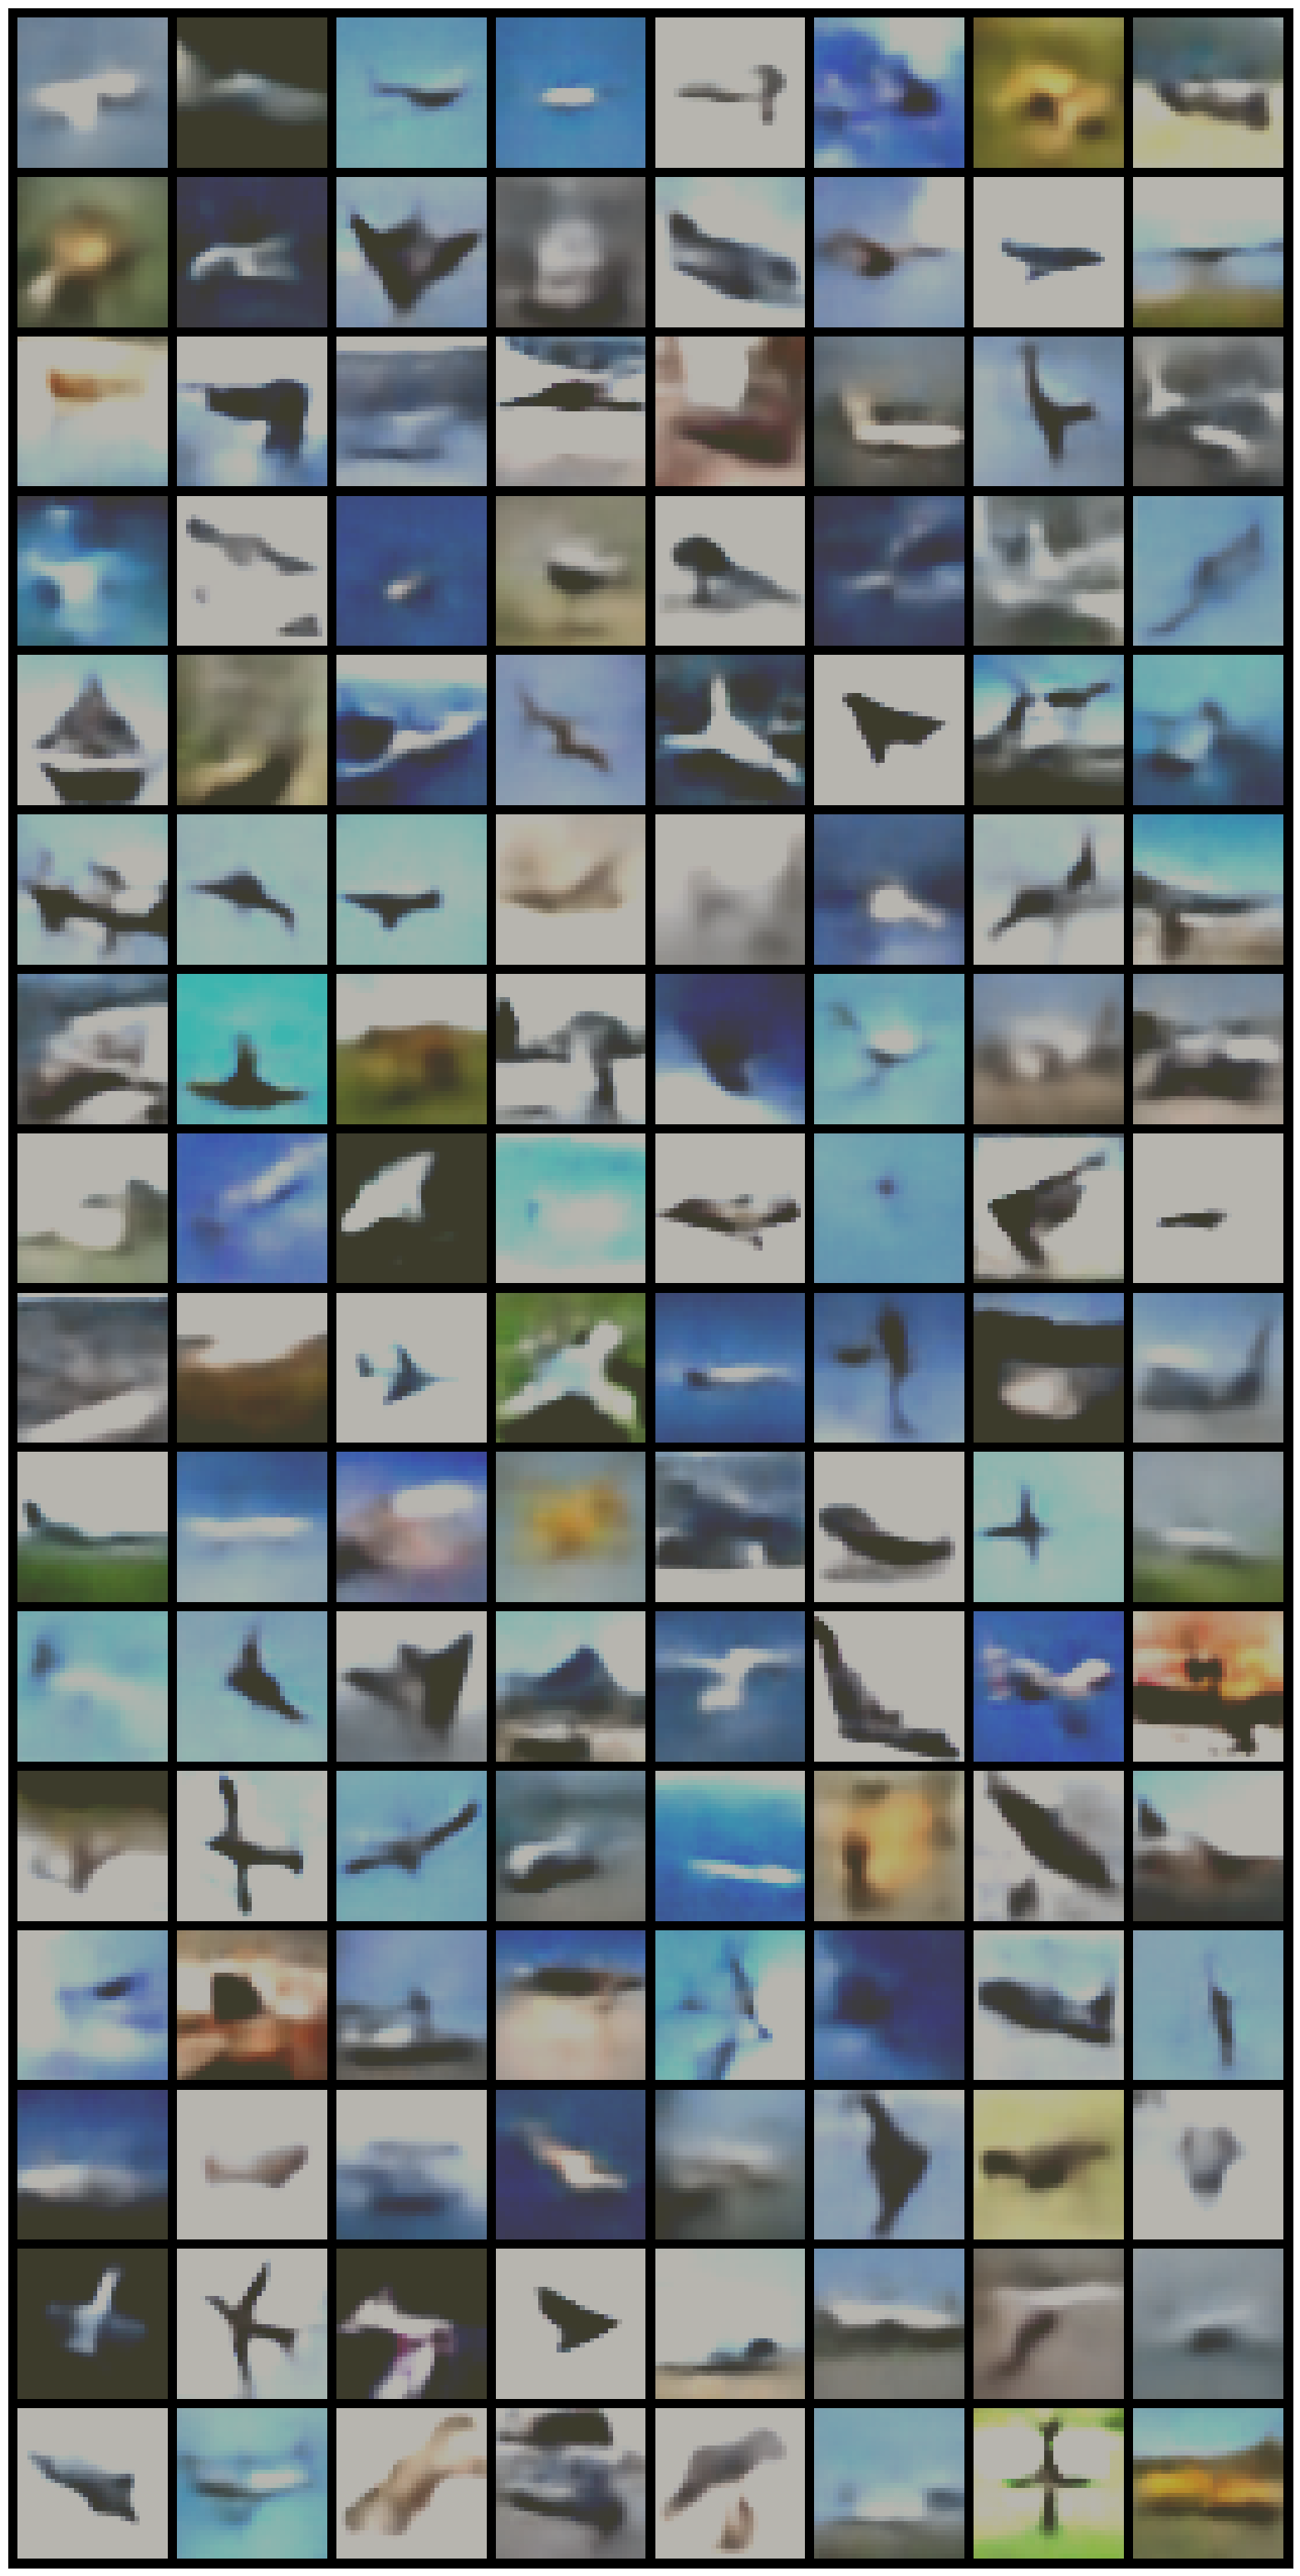

In [10]:
test_input, _ = next(iter(test_dl))
test_input = test_input.to(device)

# mean = [0.47889522, 0.47227842, 0.43047404]
# std = [0.24205776, 0.23828046, 0.25874835]

invnorm = transforms.Compose(
    [
        transforms.Normalize(mean = [0., 0., 0.], std = [1/0.24205776, 1/0.23828046, 1/0.25874835]),
        transforms.Normalize(mean = [-0.47889522, -0.47227842, -0.43047404], std = [1., 1., 1.]),
    ]
)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

    inv_recons = invnorm(recons)

grid = make_grid(inv_recons)
show(grid)

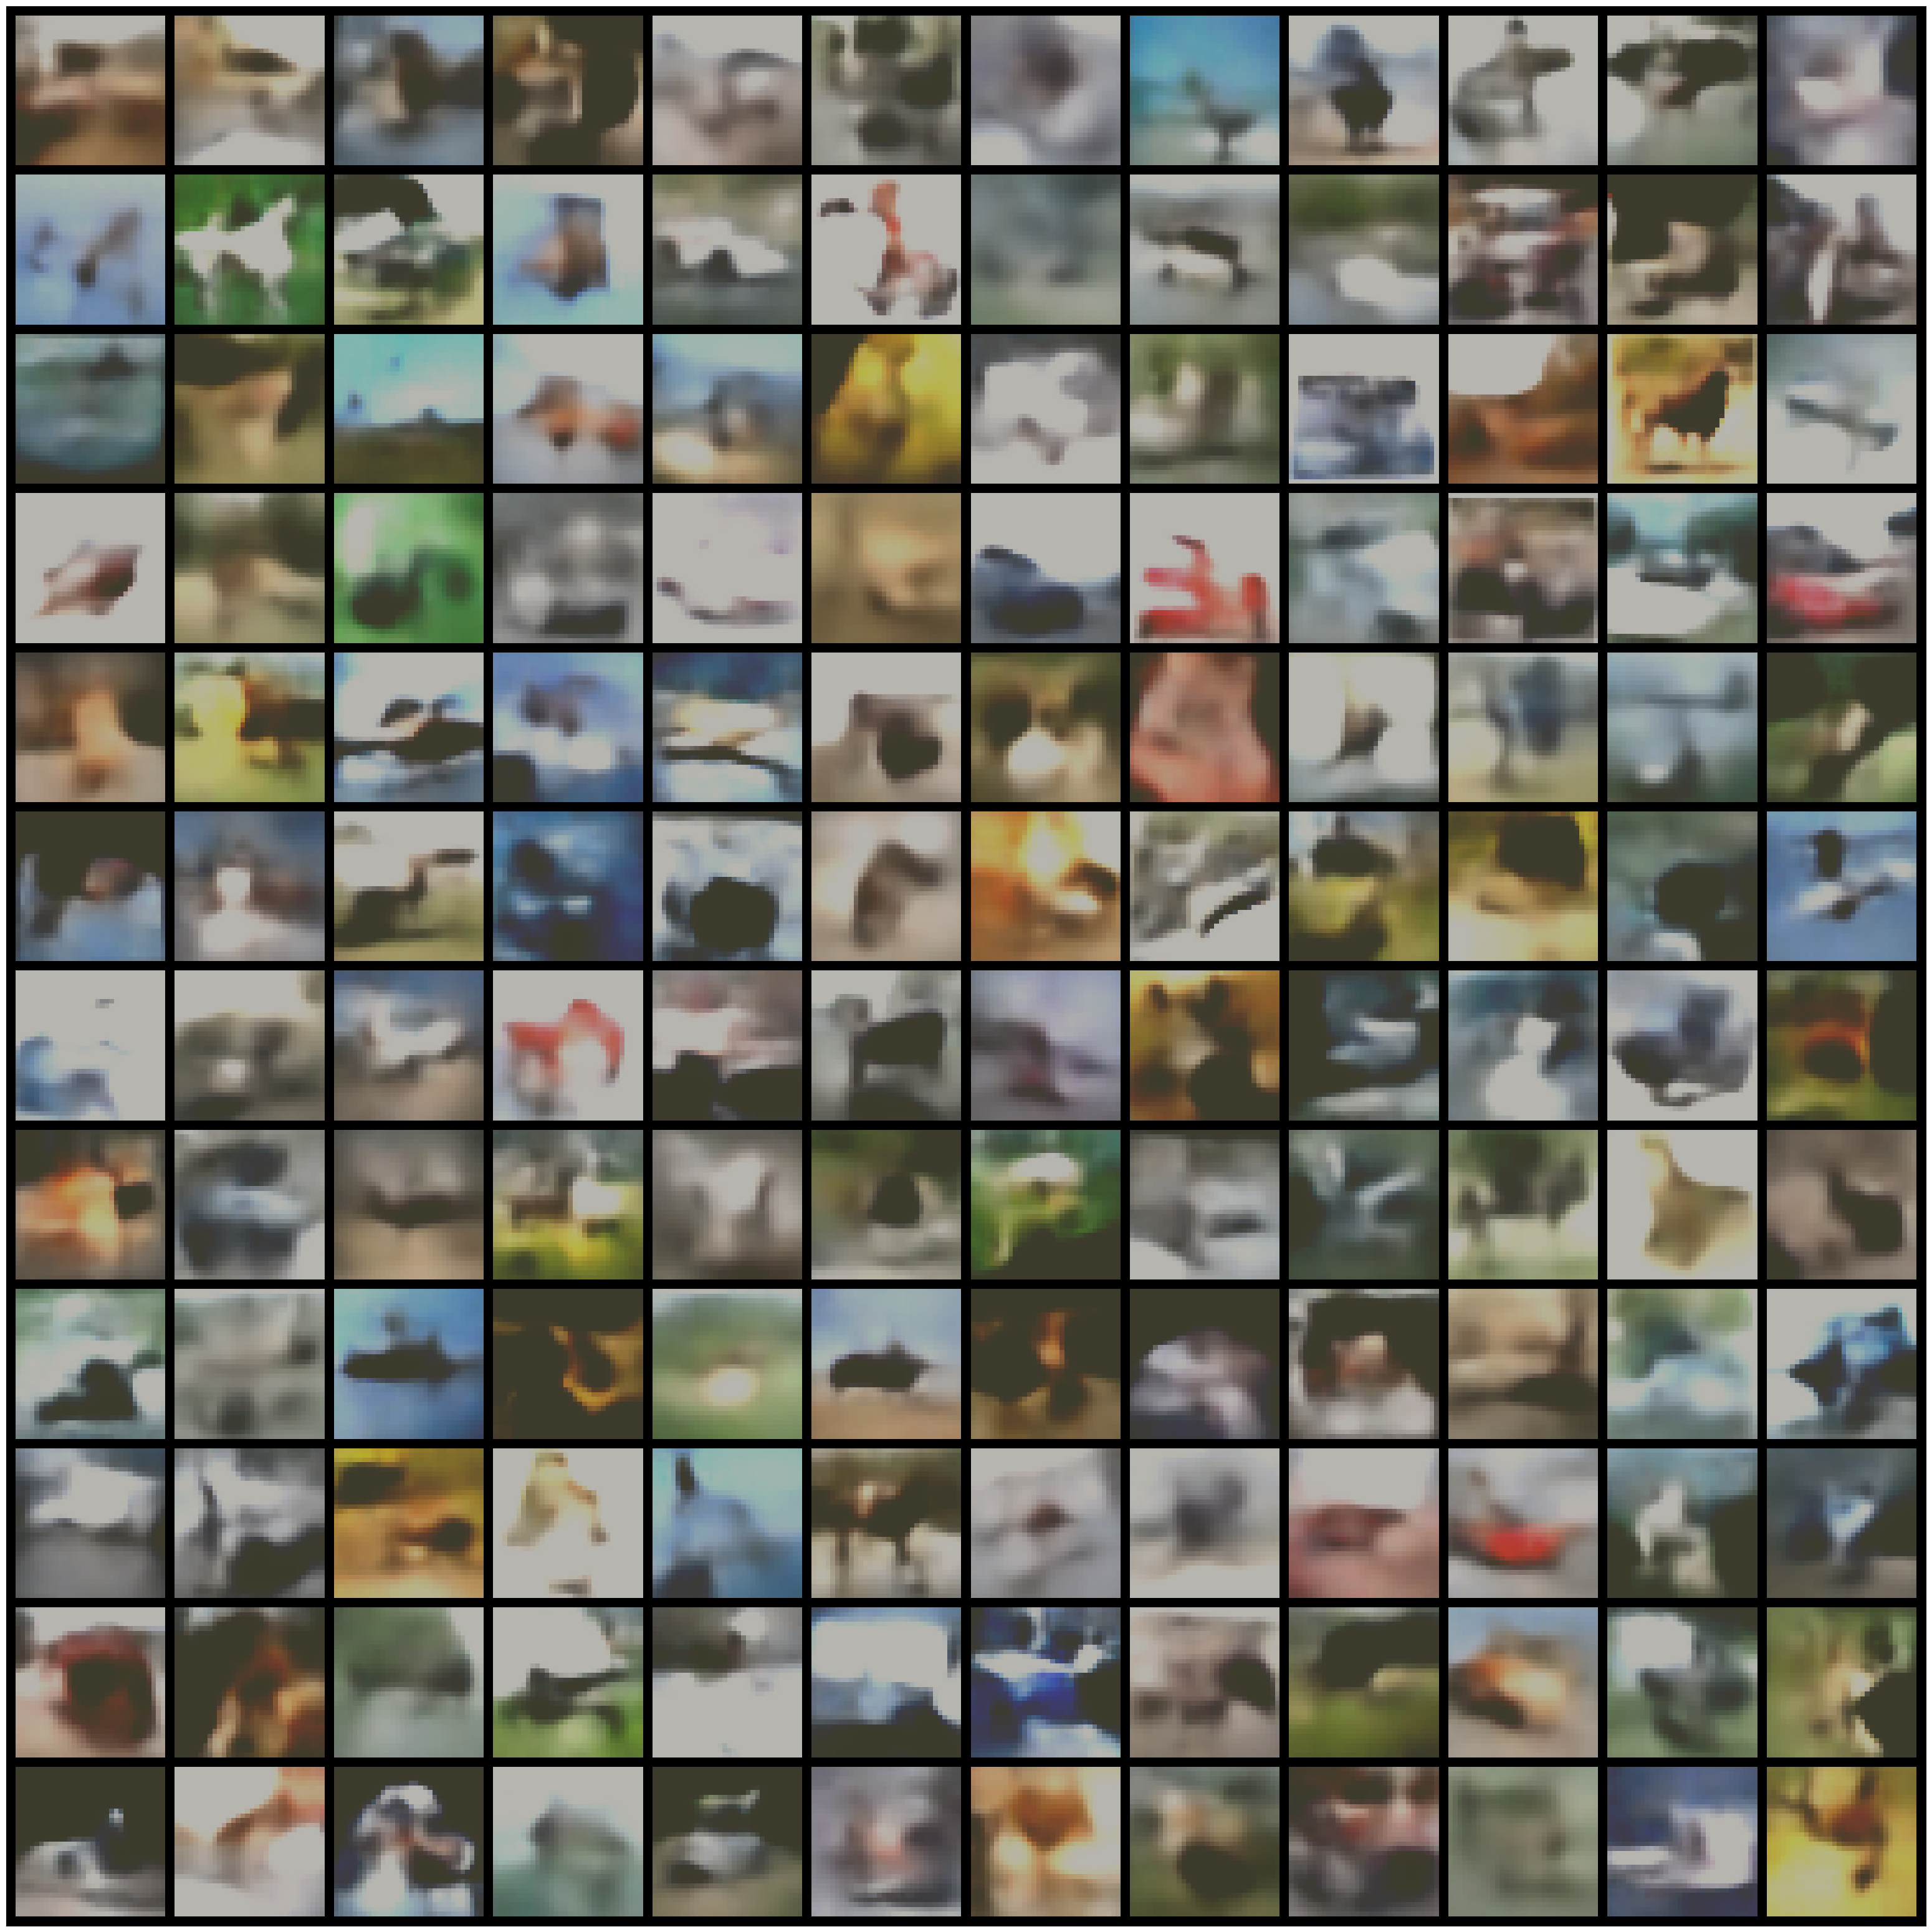

In [11]:
z = torch.randn(144, 512).to(device)

samples = model.decoder(z)

grid = make_grid(invnorm(samples), nrow=12)
show(grid)